In [1]:
!pip install torch gensim nltk --quiet

!pip install numpy==1.26.4 pandas==2.2.2 --force-reinstall --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd

# load data
df = pd.read_csv('/content/preprocessed_reviews.csv')
df = df.dropna(subset=['cleaned_text', 'sentiment_binary'])
df['sentiment_binary'] = df['sentiment_binary'].astype(int)
df.head()

# tokenization
import nltk
nltk.download('punkt_tab')
df['tokens'] = df['cleaned_text'].apply(nltk.word_tokenize)

# pretrained word2vec embedding
import gensim.downloader as api
wv = api.load("word2vec-google-news-300")
embedding_dim = 300

# build vocab, index 0 = <PAD>, 1 = <UNK>
vocab = {'<PAD>': 0, '<UNK>': 1}
for tokens in df['tokens']:
    for word in tokens:
        if word in wv and word not in vocab:
            vocab[word] = len(vocab)

# helper to convert token list to ints
def encode(tokens):
    return [vocab.get(w, 1) for w in tokens]

import torch
from torch.nn.utils.rnn import pad_sequence

# encode tokens, pad sequences, convert labels to tensor
encoded = [torch.tensor(encode(t)) for t in df['tokens']]
padded = pad_sequence(encoded, batch_first=True, padding_value=0)
labels = torch.tensor(df['sentiment_binary'].values).float()

import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split

# row i = wv vector, else random normal
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, idx in vocab.items():
    if word in wv:
        embedding_matrix[idx] = wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

# train/test split 80:20
dataset = TensorDataset(padded, labels)
train_size = int(0.8 * len(dataset))
train_set, val_set = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

import torch.nn as nn
import torch.nn.functional as F

# def model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_weights, out_channels, kernel_sizes, dropout):
        super(CNN, self).__init__()
        # embed layer init from pretrained weights, allow tuning
        self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=False)
        # list of 2D convs with diff filter heights
        self.convs = nn.ModuleList([
            nn.Conv2d(1, out_channels, (k, embedding_dim)) for k in kernel_sizes
        ])
        # dropout before final classification layer
        self.dropout = nn.Dropout(dropout)
        # final fully connected layer
        self.fc = nn.Linear(out_channels * len(kernel_sizes), 1)

    # forward pass function
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        return torch.sigmoid(self.fc(x)).squeeze(1)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [2]:
# models folder
import os
os.makedirs("models", exist_ok=True)

In [8]:
import time

# track best val acc + epoch
best_val_acc = 0.0
best_epoch = 0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# recording time
start_time = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create model, loss function, optimizer
model = CNN(len(vocab), embedding_dim, embedding_matrix, out_channels=100, kernel_sizes=[3,4,5], dropout=0.5).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adadelta(model.parameters(), rho=0.95)

for epoch in range(50):
    epoch_start = time.time() # start time for this epoch

    # switch to train mode
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        preds = model(xb) # fwd pass
        loss = criterion(preds, yb) # compute loss
        loss.backward() # bwd pass
        optimizer.step() # update weights

        total_train_loss += loss.item() * xb.size(0)
        predicted = (preds >= 0.5).float() # convert probs to 0/1 preds
        correct_train += (predicted == yb).sum().item()
        total_train += yb.size(0)

    avg_train_loss = total_train_loss / total_train
    train_acc = correct_train / total_train

    # switch to eval mode
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # no grads for validation
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_val_loss += loss.item() * xb.size(0)

            predicted = (preds >= 0.5).float()
            correct_val += (predicted == yb).sum().item()
            total_val += yb.size(0)

    avg_val_loss = total_val_loss / total_val
    val_acc = correct_val / total_val

    # save metrics to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # if best so far, save
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "models/ecs171_best_cnn.pth")
        print("new best!") # new best is below this msg

    epoch_end = time.time()
    epoch_time_ms = (epoch_end - epoch_start) * 1000
    # metrics printing
    print(f"epoch {epoch+1:02d}, time: {epoch_time_ms:.0f}ms | "
      f"train loss: {avg_train_loss:.4f}, train acc: {train_acc:.4f} | "
      f"val loss: {avg_val_loss:.4f}, val acc: {val_acc:.4f}")

elapsed = time.time() - start_time # total training time
print(f"\ntraining complete in {elapsed//60:.0f}m {elapsed%60:.0f}s")
print(f"best val acc: {best_val_acc:.4f} at epoch {best_epoch}")

new best!
epoch 01, time: 5267ms | train loss: 0.5356, train acc: 0.7295 | val loss: 0.4268, val acc: 0.7901
new best!
epoch 02, time: 5144ms | train loss: 0.3894, train acc: 0.8284 | val loss: 0.4098, val acc: 0.8199
new best!
epoch 03, time: 5259ms | train loss: 0.3235, train acc: 0.8636 | val loss: 0.3889, val acc: 0.8421
epoch 04, time: 5236ms | train loss: 0.2891, train acc: 0.8849 | val loss: 0.4136, val acc: 0.8377
epoch 05, time: 5287ms | train loss: 0.2316, train acc: 0.9150 | val loss: 0.4417, val acc: 0.8368
epoch 06, time: 5331ms | train loss: 0.1950, train acc: 0.9283 | val loss: 0.4704, val acc: 0.8392
new best!
epoch 07, time: 5425ms | train loss: 0.1548, train acc: 0.9445 | val loss: 0.4871, val acc: 0.8455
epoch 08, time: 5362ms | train loss: 0.1301, train acc: 0.9544 | val loss: 0.5647, val acc: 0.8392
epoch 09, time: 5301ms | train loss: 0.1085, train acc: 0.9634 | val loss: 0.7861, val acc: 0.8137
epoch 10, time: 5220ms | train loss: 0.0950, train acc: 0.9665 | val 

In [9]:
# eval on val set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = (model(xb) > 0.5).float()
        correct += (preds == yb).sum().item()
        total += yb.size(0)
print(f"Val Acc: {correct / total:.2%}")

Val Acc: 83.44%


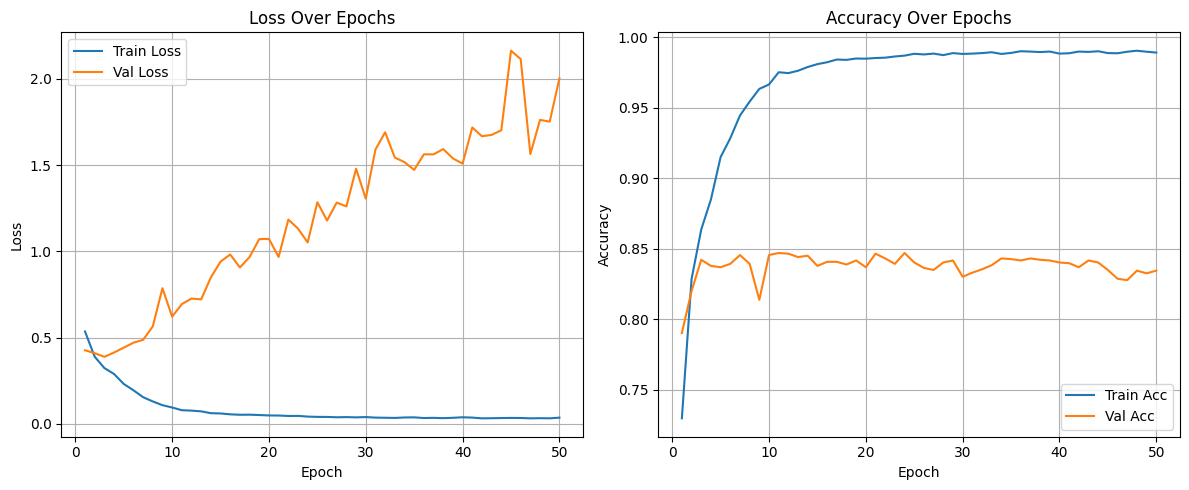

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# plot loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# plot acc curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


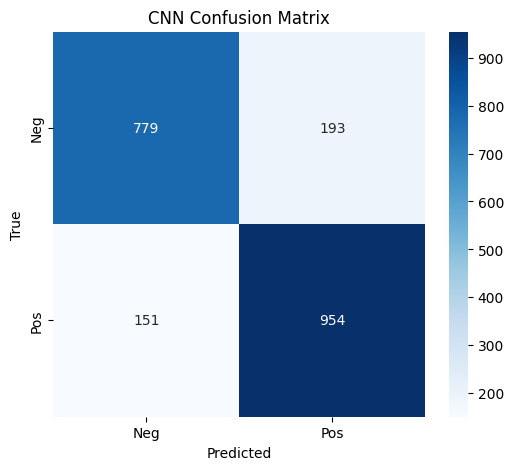

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# collect preds and true labels from val set
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = (outputs > 0.5).int().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

# make confusion matrix from labels
cm = confusion_matrix(all_labels, all_preds)
# plot cm
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.show()

In [12]:
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# save numeric metrics as JSON
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec  = recall_score(all_labels, all_preds)
f1   = f1_score(all_labels, all_preds)

metrics = {
    "model": "cnn",
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1": f1
}
with open("cnn_metrics.json", "w") as fp:
    json.dump(metrics, fp, indent=2)
print("metrics saved to cnn_metrics.json")

metrics saved to cnn_metrics.json
